In [1]:
import torch
import torch.nn as nn
import firedrake as fd
import numpy as np
import matplotlib.pyplot as plt

from burgers import BurgersDataset
from classes import ProjectionCoefficient

device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

firedrake:WARNING OMP_NUM_THREADS is not set or is set to a value greater than 1, we suggest setting OMP_NUM_THREADS=1 to improve performance


In [2]:
class NeuralOperatorLayer(nn.Module):
    def __init__(
            self,
            M: int,
            D: int,
            projection: ProjectionCoefficient,
            device: str
    ):
        """
        A network module that performs the interior layers operation in the Nonlocal Neural Operator architecture.
        This includes: Linear transformation with bias, preprojection linear transformation, projection to 'psi'
        functions (multiplication by coefficient), and nonlinearity.

        Args:
            M (int): Number of Fourier modes.
            D (int): Number of channels for fan-out.
            projection (ProjectionCoefficient): An instance of ProjectionCoefficient.
            device (str): Torch device to use ('cpu' or 'cuda').
        """
        super().__init__()

        self.M = 2 * M + 1
        self.D = D

        self.coeff = projection.coeff
        self.coeff_T = projection.coeff.T
        self.functions = projection.functions
        
        # Linear matrix multiplication that mixes up the channels (W operator), also called MLP. It includes the bias.
        self.linear = nn.Conv1d(D, D, kernel_size=1, device=device)
        # with torch.no_grad():
        #     self.linear.weight.data /= N
        #     self.linear.bias.data /= N
        

        # self.weights = nn.Parameter(torch.rand(2 * M + 1, D, D, requires_grad=True, device=device))  # MxDxD parameters

        self.linear = nn.Identity(device=device)
        self.weights = torch.eye(D, D).unsqueeze(0).repeat(2 * M + 1, 1, 1).to(device=device, dtype=torch.float32)

    
    def forward(self, u):
        wu = self.linear(u)
        s = torch.einsum("mdi, bim, mk  -> bdk", self.weights, u @ self.coeff_T, self.functions)

        return s



In [3]:
N = 64
M = 16
D = 4
with fd.CheckpointFile(f"data/burgers/meshes/N{N}.h5", "r") as file:
    mesh = file.load_mesh()
    fs = fd.FunctionSpace(mesh, "CG", 1)

# projection = ProjectionCoefficient.load(mesh, "burgers", N, D, M, "CG1", "fourier", device=device)
projection = ProjectionCoefficient(mesh, N, 1, M, "CG1", "fourier", device=device)
projection.calculate()
layer = NeuralOperatorLayer(M, D, projection, device)

x = fd.SpatialCoordinate(mesh)[0]


In [4]:
input_u = fd.Function(fs)
input_u.interpolate(fd.exp(-10*(x-0.5)**2) + x**2)
input_u_coeff = torch.tensor(input_u.dat.data).unsqueeze(0).repeat(4, 1).unsqueeze(0).to(device=device, dtype=torch.float32)

In [5]:
func2 = fd.Function(fs)
input_u.interpolate(fd.tan(x))
input_u_coeff[0, 1, :] = torch.tensor(input_u.dat.data).to(device=device, dtype=torch.float32)

In [6]:
layer(input_u_coeff).shape

torch.Size([1, 4, 64])

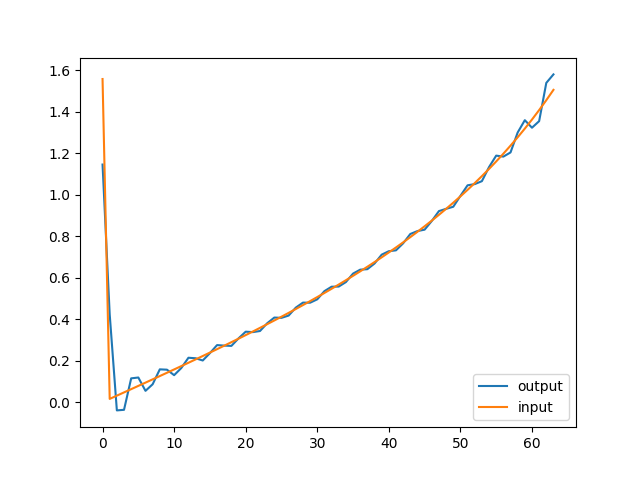

In [8]:
%matplotlib widget

plt.figure()
plt.plot((layer(input_u_coeff))[0, 1, :].cpu().detach(), label="output")
plt.plot(input_u_coeff[0, 1, :].cpu().detach(), label="input")
plt.legend()
plt.show()


In [ ]:
fs = fd.FunctionSpace(mesh, "CG", 1)

fig, axes = plt.subplots()
fd.plot(fd.Function(fs, val=input_u_coeff.flatten().cpu().detach(), name="Input"), axes=axes)
fd.plot(fd.Function(fs, val=layer(input_u_coeff).flatten().cpu().detach(), name="Output"), axes=axes)
axes.legend()

In [7]:
psi_arr = []
for i in range(2*M + 1):
    psi_arr.append(fd.Function(fs, val=(projection.coeff[i, :]).flatten().cpu().detach(), name=f"Mode {i}"))


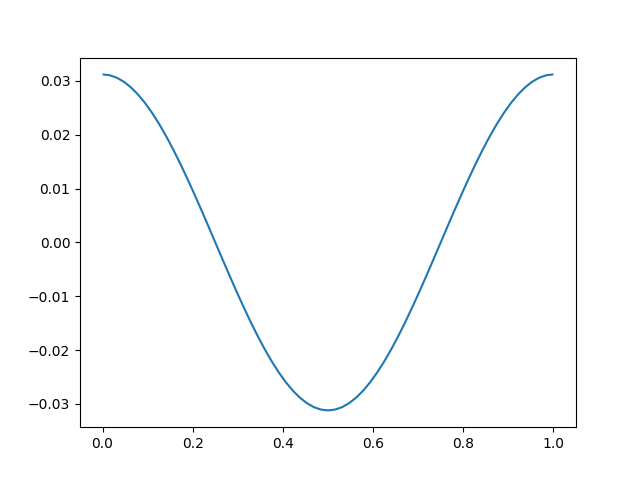

In [8]:
fd.plot(psi_arr[2])

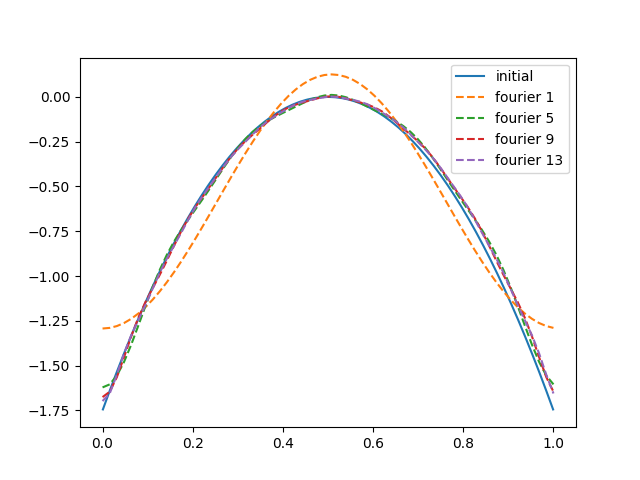

In [9]:
%matplotlib widget

import torch
import firedrake as fd
import numpy as np
import matplotlib.pyplot as plt

from classes import ProjectionCoefficient


if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    N, M, D, L = 64, 16, 10, 1

    with fd.CheckpointFile(f"data/burgers/meshes/N{N}.h5", "r") as file:
        mesh = file.load_mesh()

    x = fd.SpatialCoordinate(mesh)[0]
    fs = fd.FunctionSpace(mesh, "CG", 1)

    fs_out = fd.FunctionSpace(mesh, "CG", 3)

    projection = ProjectionCoefficient(mesh, N, 1, M, "CG1", "fourier", device=device)
    projection.calculate()

    initial_function = fd.Function(fs, name="initial")
    initial_function.interpolate(-(7*(x-0.5)**2))

    fig, axes = plt.subplots()
    fd.plot(initial_function, axes=axes, label="initial")

    psi_arr = []
    for i in range(2*M + 1):
        if i == 0:
            psi_arr.append(fd.Function(fs, name=f"Mode {i}").interpolate(1))
            continue

        psi_arr.append(fd.Function(fs, name=f"Mode {i}").interpolate(fd.sin(i * 2 * fd.pi * x)))
        psi_arr.append(fd.Function(fs, name=f"Mode {i}").interpolate(fd.cos(i * 2 * fd.pi * x)))



        # psi_arr.append(fd.Function(fs, val=130 * projection.coeff[i, :].cpu().detach().numpy(), name=f"Mode {i}"))
    x = np.linspace(0, 1, 64)
    for truncate in range(1, M, 4):
        fourier = np.zeros(N)
        for m in range(truncate * 2 + 1):
            m_coeff = 0
            for n in range(N):
                m_coeff += initial_function.dat.data[n] * projection.coeff[m, n].cpu().numpy()
                
            fourier += m_coeff * projection.functions[m, :].cpu().numpy()

        axes.plot(x, fourier, label=f"fourier {truncate}", linestyle="--")
    # fd.plot(psi_arr[0], axes=axes)
    # fd.plot(psi_arr[1], axes=axes)
    # fd.plot(psi_arr[2], axes=axes)
    # fd.plot(psi_arr[6], axes=axes)
    axes.legend()
